In [1]:
import random

class EaterEnvironment:
    def __init__(self, mover_policy, grid_size=7, g1_state=37, g2_state=49, initial_bananas_g1=100, initial_bananas_g2=100):
        self.mover_policy = mover_policy
        self.grid_size = grid_size
        self.g1 = self.state_to_position(g1_state)
        self.g2 = self.state_to_position(g2_state)
        self.bananas_g1 = initial_bananas_g1
        self.bananas_g2 = initial_bananas_g2
        self.actions = [
            (1, 0), (0, 1), (0.5, 0.5), (0.2, 0.8), (0.6, 0.4),
            (0.8, 0.2), (0.4, 0.6), (0.7, 0.3), (0.3, 0.7)
        ]
        self.initial_mover_state = 1
        self.current_mover_state = self.initial_mover_state
        self.current_mover_action = 0
        self.done = False
        self.action_history = []
        self.min_distance_to_g1 = float('inf')
        self.min_distance_to_g2 = float('inf')
        self.deception_detected = False
        self.assumed_true_goal = None  # Assumed true goal after deception is detected

    def reset(self):
        self.current_mover_state = 1
        self.current_mover_action = random.choice(range(len(self.actions)))
        self.done = False
        self.action_history.clear()
        self.min_distance_to_g1 = float('inf')
        self.min_distance_to_g2 = float('inf')
        self.deception_detected = False
        self.assumed_true_goal = None
        return (self.current_mover_state, self.current_mover_action)

    # Assume other methods like state_to_position, calculate_distance, etc., are defined here.
    def update_position(self, position, action):
        x, y = position
        if action == 0 and y < self.grid_size - 1:
            y += 1
        elif action == 1 and y > 0:
            y -= 1
        elif action == 2 and x > 0:
            x -= 1
        elif action == 3 and x < self.grid_size - 1:
            x += 1
        return (x, y)

    def position_to_state(self, position):
        x, y = position
        return y * self.grid_size + x + 1

    def detect_deception(self, previous_distance, current_distance, goal_position):
        # Simple deception detection based on moving away from a goal when very close
        if previous_distance < 2 and current_distance > 1:
            return True
        return False

    def step(self, eater_state, action_index):
        self.current_mover_state, _ = eater_state
        mover_position = self.state_to_position(self.current_mover_state)
        self.current_mover_action = self.mover_policy[mover_position]
        self.action_history.append(self.current_mover_action)  # Record action
        mover_next_position = self.update_position(mover_position, self.current_mover_action)
        next_mover_state = self.position_to_state(mover_next_position)

        previous_distance_to_g1 = self.calculate_distance(mover_position, self.g1)
        previous_distance_to_g2 = self.calculate_distance(mover_position, self.g2)

        current_distance_to_g1 = self.calculate_distance(mover_next_position, self.g1)
        current_distance_to_g2 = self.calculate_distance(mover_next_position, self.g2)

        if self.detect_deception(previous_distance_to_g1, current_distance_to_g1, self.g1):
            self.deception_detected = True
            self.assumed_true_goal = self.g2
        elif self.detect_deception(previous_distance_to_g2, current_distance_to_g2, self.g2):
            self.deception_detected = True
            self.assumed_true_goal = self.g1

        reward = self.calculate_reward(current_distance_to_g1, current_distance_to_g2, action_index)

        goal1_consume, goal2_consume = self.actions[action_index]
        if self.deception_detected:
            action_index = self.maximize_consumption(self.assumed_true_goal)
            goal1_consume, goal2_consume = self.actions[action_index]
        self.bananas_g1 -= goal1_consume
        self.bananas_g2 -= goal2_consume
        next_state = (next_mover_state, self.current_mover_action)
        if self.current_mover_action == 4:
            self.done = True
        return next_state, reward, self.done

    def maximize_consumption(self, assumed_true_goal):
        # Determine which action maximizes consumption from the assumed true goal
        if assumed_true_goal == self.g1:
            return 0  # Maximum consumption from g1
        else:
            return 1  # Maximum consumption from g2

    def calculate_reward(self, distance_to_g1, distance_to_g2, action_index):
        # Extend the reward calculation with deception detection and path prediction
        ideal_g1_ratio = distance_to_g2 / (distance_to_g1 + distance_to_g2) if (distance_to_g1 + distance_to_g2) != 0 else 0
        ideal_g2_ratio = 1 - ideal_g1_ratio
        action_ratios = {
            0: (1.0, 0.0), 1: (0.0, 1.0), 2: (0.5, 0.5), 3: (0.2, 0.8), 4: (0.6, 0.4),
            5: (0.8, 0.2), 6: (0.4, 0.6), 7: (0.7, 0.3), 8: (0.3, 0.7)
        }
        actual_g1_ratio, actual_g2_ratio = action_ratios[action_index]
        diff_g1 = abs(actual_g1_ratio - ideal_g1_ratio)
        diff_g2 = abs(actual_g2_ratio - ideal_g2_ratio)
        reward = 1 - (diff_g1 + diff_g2)

        # Path prediction and deception detection
        predicted_path = self.predict_future_path()
        actual_path = self.current_mover_state
        return reward

    def state_to_position(self, state):
        x = (state - 1) % self.grid_size
        y = (state - 1) // self.grid_size
        return (x, y)

    def calculate_distance(self, pos1, pos2):
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    def predict_future_path(self):
        # Simple path prediction based on the last observed action
        if not self.action_history:
            return self.current_mover_state  # No history, return current state
        last_action = self.action_history[-1]
        predicted_next_position = self.update_position(self.state_to_position(self.current_mover_state), last_action)


In [2]:
mover_policy  = {(0, 0): 0,
 (0, 1): 0,
 (0, 2): 0,
 (0, 3): 0,
 (0, 4): 0,
 (0, 5): 3,
 (0, 6): 1,
 (1, 0): 2,
 (1, 1): 1,
 (1, 2): 2,
 (1, 3): 2,
 (1, 4): 0,
 (1, 5): 3,
 (1, 6): 1,
 (2, 0): 2,
 (2, 1): 0,
 (2, 2): 0,
 (2, 3): 2,
 (2, 4): 0,
 (2, 5): 3,
 (2, 6): 2,
 (3, 0): 0,
 (3, 1): 0,
 (3, 2): 0,
 (3, 3): 0,
 (3, 4): 0,
 (3, 5): 0,
 (3, 6): 3,
 (4, 0): 2,
 (4, 1): 0,
 (4, 2): 0,
 (4, 3): 2,
 (4, 4): 2,
 (4, 5): 0,
 (4, 6): 3,
 (5, 0): 2,
 (5, 1): 1,
 (5, 2): 3,
 (5, 3): 3,
 (5, 4): 0,
 (5, 5): 0,
 (5, 6): 3,
 (6, 0): 1,
 (6, 1): 1,
 (6, 2): 3,
 (6, 3): 0,
 (6, 4): 0,
 (6, 5): 2,
 (6, 6): 4}

In [3]:

import random

env = EaterEnvironment(mover_policy)
next_state = (1,0)
for i in range(10):
  action = random.choice(range(len(env.actions)))
  next_state, reward, done = env.step(next_state, action)
  print(next_state,action,reward)


(8, 0) 1 -0.375
(15, 0) 0 0.4285714285714286
(22, 0) 8 0.10000000000000009
(29, 0) 1 -0.6000000000000001
(36, 0) 2 0.25
(37, 3) 4 0.19999999999999996
(38, 3) 7 0.7333333333333332
(39, 3) 1 -0.33333333333333326
(46, 0) 0 0.0
(47, 3) 8 0.9333333333333335


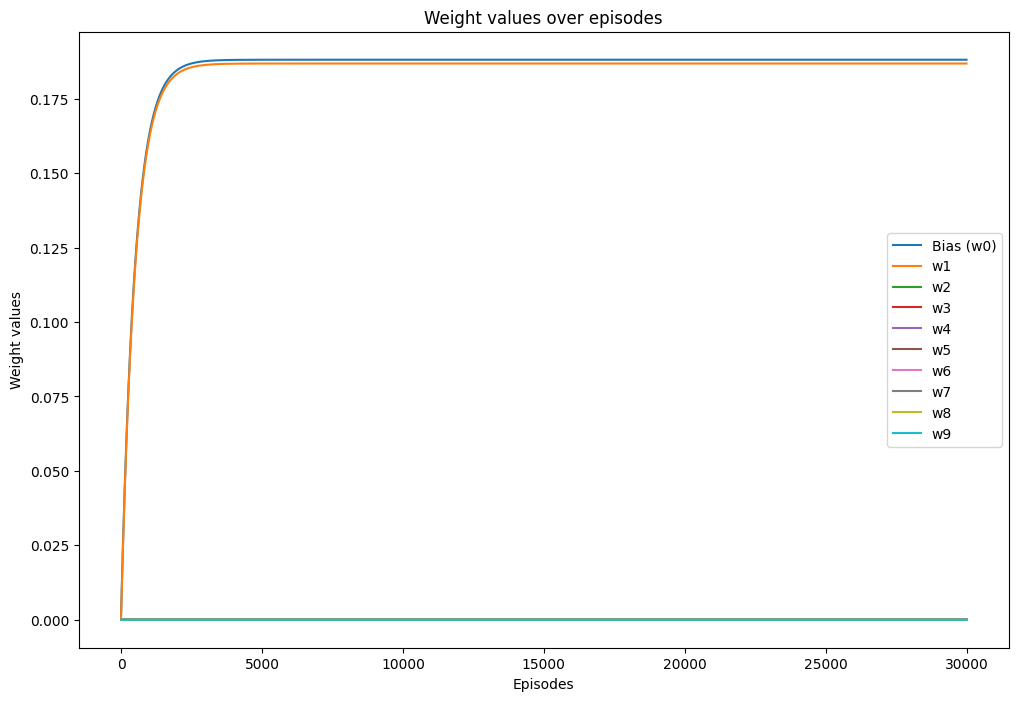

Final weights after training: [ 1.88137798e-01  1.86862202e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000

In [4]:
import numpy as np
import matplotlib.pyplot as plt



# The feature dimension is (grid size * grid size) * number of actions + 1 (for the bias term)
feature_dim = 1 + env.grid_size ** 2 * len(env.actions)
w = np.zeros(feature_dim)  # Initialize weights

# Feature vector representation that encodes mover position and eater action
def feature_vector(state, eater_action):
    features = np.zeros(feature_dim)
    features[0] = 1  # Bias term
    mover_position = env.position_to_state(env.state_to_position(state[0])) - 1
    action_offset = mover_position * len(env.actions) + eater_action
    features[1 + action_offset] = 1  # One-hot encode mover position and eater action
    return features

# Value function estimate using linear function approximation
def v_hat(state, eater_action, w):
    return np.dot(w, feature_vector(state, eater_action))

# Policy function for the eater: chooses action based on current mover position
def policy_function(state,w):
    return np.argmax([v_hat(state, action, w) for action in range(len(env.actions))])

# Semi-gradient TD learning algorithm
def semi_gradient_td(w, alpha, gamma, total_episodes, T):
    w_history = np.zeros((total_episodes, len(w)))  # Store history of weights for plotting
    for episode in range(total_episodes):
        state = (1, 0)  # Start with an initial state
        for t in range(T):
            action = policy_function(state,w)
            next_state, reward, done= env.step(state, action)
            next_action = policy_function(next_state,w)
            grad_v = feature_vector(state, action)
            td_target = reward + gamma * v_hat(next_state, next_action, w) * (not done)
            td_error = td_target - v_hat(state, action, w)
            w += alpha * td_error * grad_v
            state = next_state
            if done:
              break

        w_history[episode] = w

    return w, w_history

# Parameters
alpha = 0.001  # Step size
gamma = 0.99  # Discount factor
total_episodes = 30000  # Reduced number for manageable simulations
T = 500  # Length of an episode
# Run the learning algorithm
final_weights, weights_history = semi_gradient_td(w, alpha, gamma, total_episodes, T)

# Plotting the evolution of weights
plt.figure(figsize=(12, 8))
plt.plot(weights_history[:, 0], label='Bias (w0)')
for i in range(1, min(10, len(w))):
    plt.plot(weights_history[:, i], label=f'w{i}')
plt.xlabel('Episodes')
plt.ylabel('Weight values')
plt.title('Weight values over episodes')
plt.legend()
plt.show()

# Print the final weights
print("Final weights after training:", final_weights)

In [5]:
policy_dict = {}
for mover_position in range(1, env.grid_size ** 2 + 1):
    for mover_action in range(4):
        state = (mover_position, mover_action)
        best_action = policy_function(state, final_weights)  # Use the final_weights after training
        policy_dict[state] = best_action


In [6]:
print(policy_dict)

{(1, 0): 0, (1, 1): 0, (1, 2): 0, (1, 3): 0, (2, 0): 0, (2, 1): 0, (2, 2): 0, (2, 3): 0, (3, 0): 0, (3, 1): 0, (3, 2): 0, (3, 3): 0, (4, 0): 0, (4, 1): 0, (4, 2): 0, (4, 3): 0, (5, 0): 0, (5, 1): 0, (5, 2): 0, (5, 3): 0, (6, 0): 0, (6, 1): 0, (6, 2): 0, (6, 3): 0, (7, 0): 0, (7, 1): 0, (7, 2): 0, (7, 3): 0, (8, 0): 0, (8, 1): 0, (8, 2): 0, (8, 3): 0, (9, 0): 0, (9, 1): 0, (9, 2): 0, (9, 3): 0, (10, 0): 0, (10, 1): 0, (10, 2): 0, (10, 3): 0, (11, 0): 0, (11, 1): 0, (11, 2): 0, (11, 3): 0, (12, 0): 0, (12, 1): 0, (12, 2): 0, (12, 3): 0, (13, 0): 0, (13, 1): 0, (13, 2): 0, (13, 3): 0, (14, 0): 0, (14, 1): 0, (14, 2): 0, (14, 3): 0, (15, 0): 0, (15, 1): 0, (15, 2): 0, (15, 3): 0, (16, 0): 0, (16, 1): 0, (16, 2): 0, (16, 3): 0, (17, 0): 0, (17, 1): 0, (17, 2): 0, (17, 3): 0, (18, 0): 0, (18, 1): 0, (18, 2): 0, (18, 3): 0, (19, 0): 0, (19, 1): 0, (19, 2): 0, (19, 3): 0, (20, 0): 0, (20, 1): 0, (20, 2): 0, (20, 3): 0, (21, 0): 0, (21, 1): 0, (21, 2): 0, (21, 3): 0, (22, 0): 0, (22, 1): 0, (22

In [7]:
# Re-instantiate the environment with the provided mover policy
env = EaterEnvironment(mover_policy)
state = env.reset()
for i in range(19):
    action_index = policy_function(state, final_weights)  # Use the learned policy
    next_state, reward, done = env.step(state, action_index)
    if done:
        print(f"Step {i+1}: Episode ended. Final State: {next_state}, Reward: {reward}, Action: {env.actions[action_index]}, Bananas at g1: {env.bananas_g1}, Bananas at g2: {env.bananas_g2}")
        break
    else:
        print(f"Step {i+1}: Next State: {next_state}, Reward: {reward}, Action: {env.actions[action_index]}, Bananas at g1: {env.bananas_g1}, Bananas at g2: {env.bananas_g2}")
    state = next_state


Step 1: Next State: (8, 0), Reward: 0.375, Action: (1, 0), Bananas at g1: 99, Bananas at g2: 100
Step 2: Next State: (15, 0), Reward: 0.4285714285714286, Action: (1, 0), Bananas at g1: 98, Bananas at g2: 100
Step 3: Next State: (22, 0), Reward: 0.5, Action: (1, 0), Bananas at g1: 97, Bananas at g2: 100
Step 4: Next State: (29, 0), Reward: 0.6000000000000001, Action: (1, 0), Bananas at g1: 96, Bananas at g2: 100
Step 5: Next State: (36, 0), Reward: 0.75, Action: (1, 0), Bananas at g1: 95, Bananas at g2: 100
Step 6: Next State: (37, 3), Reward: 1.0, Action: (1, 0), Bananas at g1: 94, Bananas at g2: 100
Step 7: Next State: (38, 3), Reward: 0.6666666666666667, Action: (1, 0), Bananas at g1: 93, Bananas at g2: 100
Step 8: Next State: (39, 3), Reward: 0.33333333333333326, Action: (1, 0), Bananas at g1: 93, Bananas at g2: 99
Step 9: Next State: (46, 0), Reward: 0.0, Action: (0, 1), Bananas at g1: 93, Bananas at g2: 98
Step 10: Next State: (47, 3), Reward: 0.3333333333333335, Action: (0, 1), B